# Getting started with PPO and ProcGen

Here's a bit of code that should help you get started on your projects.

The cell below installs `procgen` and downloads a small `utils.py` script that contains some utility functions. You may want to inspect the file for more details.

In [ ]:
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py

     |████████████████████████████████| 39.9MB 85kB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 22.2MB 106kB/s 
     |████████████████████████████████| 3.3MB 48.0MB/s 
     |████████████████████████████████| 204kB 50.3MB/s 
     |████████████████████████████████| 665kB 39.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
--2020-11-22 23:23:48--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py’

In [ ]:
import utils

Hyperparameters. These values should be a good starting point. You can modify them later once you have a working implementation.

In [ ]:
# Hyperparameters
total_steps = 8e6
num_envs = 32
num_levels = 1000
num_steps = 256
num_epochs = 3
batch_size = 512
eps = .2
grad_eps = .5
value_coef = .5
entropy_coef = .01

Network definitions. We have defined a policy network for you in advance. It uses the popular `NatureDQN` encoder architecture (see below), while policy and value functions are linear projections from the encodings. There is plenty of opportunity to experiment with architectures, so feel free to do that! Perhaps implement the `Impala` encoder from [this paper](https://arxiv.org/pdf/1802.01561.pdf) (perhaps minus the LSTM).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import make_env, Storage, orthogonal_init


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class Encoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.feat_convs = []
    self.resnet1 = []
    self.resnet2 = []

    self.convs = []
    input_channels = in_channels 
    for num_ch in [16, 32, 32]:
        feats_convs = []
        feats_convs.append(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=num_ch,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        feats_convs.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.feat_convs.append(nn.Sequential(*feats_convs))

        input_channels = num_ch

        for i in range(2):
            resnet_block = []
            resnet_block.append(nn.ReLU())
            resnet_block.append(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=num_ch,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
            )
            resnet_block.append(nn.ReLU())
            resnet_block.append(
                nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=num_ch,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
            )
            if i == 0:
                self.resnet1.append(nn.Sequential(*resnet_block))
            else:
                self.resnet2.append(nn.Sequential(*resnet_block))

    self.feat_convs = nn.ModuleList(self.feat_convs)
    self.resnet1 = nn.ModuleList(self.resnet1)
    self.resnet2 = nn.ModuleList(self.resnet2)

    self.flatten = Flatten()
    self.lin = nn.Sequential(
        nn.Linear(in_features=2048, out_features=feature_dim), nn.ReLU()
    )
    self.apply(orthogonal_init)

  def forward(self, x):
    for i, fconv in enumerate(self.feat_convs):
        x = fconv(x)
        res_input = x
        x = self.resnet1[i](x)
        x += res_input
        res_input = x
        x = self.resnet2[i](x)
        x += res_input
    #print("testing xshape: ", x.shape)
    x = self.flatten(x)
    #print("flatten xshape", x.shape)
    x = self.lin(x)
    return x


class Policy(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    #print("input shape: ", x.shape)
    x = self.encoder(x)
    #print("afterencoder shape: ", x.shape)
    logits = self.policy(x)
    value = self.value(x).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)

    return dist, value


# Define environment
# check the utils.py file for info on arguments
env = make_env(num_envs, num_levels=num_levels)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space.n)

# Define network
in_channels,_,_ = env.observation_space.shape
feature_dim = 256
num_actions = env.action_space.n
encoder = Encoder(in_channels=in_channels,feature_dim=feature_dim)
policy = Policy(encoder=encoder,feature_dim=feature_dim,num_actions=num_actions)
policy.cuda()

# Define optimizer
# these are reasonable values but probably not optimal
optimizer = torch.optim.Adam(policy.parameters(), lr=5e-4, eps=1e-5)

# Define temporary storage
# we use this to collect transitions during each iteration
storage = Storage(
    env.observation_space.shape,
    num_steps,
    num_envs
)

# Run training
obs = env.reset()
reward_storage = 0
step_storage = 0
step = 0
while step < total_steps:

  # Use policy to collect data for num_steps steps
  policy.eval()
  for _ in range(num_steps):
    # Use policy
    action, log_prob, value = policy.act(obs)
    
    # Take step in environment
    next_obs, reward, done, info = env.step(action)

    # Store data
    storage.store(obs, action, reward, done, info, log_prob, value)
    
    # Update current observation
    obs = next_obs

  # Add the last observation to collected data
  _, _, value = policy.act(obs)
  storage.store_last(obs, value)

  # Compute return and advantage
  storage.compute_return_advantage()

  # Optimize policy
  policy.train()
  for epoch in range(num_epochs):

    # Iterate over batches of transitions
    generator = storage.get_generator(batch_size)
    for batch in generator:
      b_obs, b_action, b_log_prob, b_value, b_returns, b_advantage = batch

      # Get current policy outputs
      new_dist, new_value = policy(b_obs)
      new_log_prob = new_dist.log_prob(b_action)

      # Clipped policy objective
      ratio = torch.exp(new_log_prob - b_log_prob)
      clipped_ratio = ratio.clamp(min=1.0 - eps,
                                  max=1.0 + eps)
      policy_reward = torch.min(ratio * b_advantage,
                                clipped_ratio * b_advantage)
      pi_loss = -policy_reward.mean()

      # Clipped value function objective
      clipped_value = (new_value - b_value)**2
      value_loss = clipped_value.mean()

      # Entropy loss
      entropy_loss = new_dist.entropy().mean()

      # Backpropagate losses
      loss = pi_loss + value_coef*value_loss + entropy_coef*entropy_loss
      loss.backward()

      # Clip gradients
      torch.nn.utils.clip_grad_norm_(policy.parameters(), grad_eps)

      # Update policy
      optimizer.step()
      optimizer.zero_grad()

  # Update stats
  step += num_envs * num_steps
  print(f'Step: {step}\tMean reward: {storage.get_reward()}')
  reward_storage = np.append(reward_storage, storage.get_reward())
  step_storage = np.append(step_storage, step)
print('Completed training!')
torch.save(policy.state_dict, 'checkpoint.pt')

Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
Step: 8192	Mean reward: 3.375
Step: 16384	Mean reward: 4.71875
Step: 24576	Mean reward: 3.96875
Step: 32768	Mean reward: 4.125
Step: 40960	Mean reward: 4.0625
Step: 49152	Mean reward: 4.1875
Step: 57344	Mean reward: 4.4375
Step: 65536	Mean reward: 3.15625
Step: 73728	Mean reward: 3.3125
Step: 81920	Mean reward: 3.5625
Step: 90112	Mean reward: 2.75
Step: 98304	Mean reward: 2.9375
Step: 106496	Mean reward: 3.90625
Step: 114688	Mean reward: 2.8125
Step: 122880	Mean reward: 3.28125
Step: 131072	Mean reward: 3.0
Step: 139264	Mean reward: 4.25
Step: 147456	Mean reward: 2.90625
Step: 155648	Mean reward: 3.59375
Step: 163840	Mean reward: 3.4375
Step: 172032	Mean reward: 2.875
Step: 180224	Mean reward: 3.125
Step: 188416	Mean reward: 2.65625
Step: 196608	Mean reward: 3.125
Step: 204800	Mean reward: 3.125
Step: 212992	Mean reward: 2.5625
Step: 221184	Mean reward: 2.90625
Step: 229376	Mean reward: 2.75
Step: 237568	Mean rewar

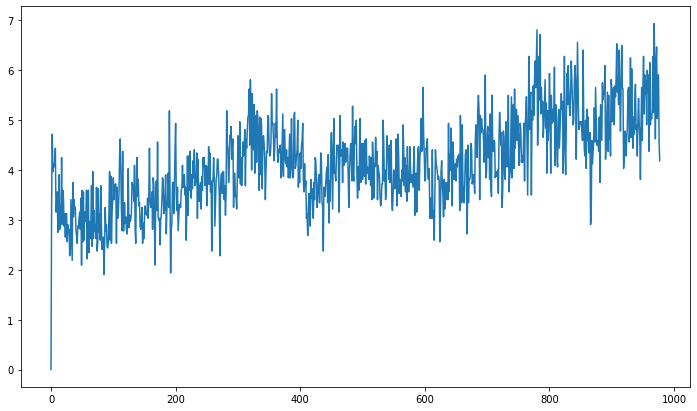

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 7))
ax.grid()
ax.plot(step_storage, reward_storage)
fig.savefig('Rewards.png')

Below cell can be used for policy evaluation and saves an episode to mp4 for you to view.

In [ ]:
import imageio

# Make evaluation environment
eval_env = make_env(num_envs, start_level=num_levels, num_levels=num_levels)
obs = eval_env.reset()

frames = []
total_reward = []

# Evaluate policy
policy.eval()
for _ in range(512):

  # Use policy
  action, log_prob, value = policy.act(obs)

  # Take step in environment
  obs, reward, done, info = eval_env.step(action)
  total_reward.append(torch.Tensor(reward))

  # Render environment and store
  frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
  frames.append(frame)

# Calculate average return
total_reward = torch.stack(total_reward).sum(0).mean(0)
print('Average return:', total_reward)

# Save frames as video
frames = torch.stack(frames)
imageio.mimsave('vid_starpilot.mp4', frames, fps=25)

Average return: tensor(10.8415)


In [ ]:
from google.colab import files
files.download('vid_starpilot.mp4') 
files.download('Rewards.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>